In [1]:
from bagpy import bagreader
import os

import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R


import matplotlib.pyplot as plt
import yaml

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Python older than 3.7 detected. 


In [2]:
root = '/home/pierre/workspace/uuv_ws/src/mppi_ros/log/marine_paper/cascade_pid/static_cost/bags'
bag_name = "forward_2023-07-05-11-52-51"

bag_file = os.path.join(root, bag_name + ".bag")
goal_file = os.path.join(root, bag_name + ".yaml")


In [3]:
bag = bagreader(bag_file, verbose=True)

# for t in bag.topics:
#     print(t)

foo = bag.message_by_topic("/pid1/errors/x")

[INFO]  Successfully created the data folder /home/pierre/workspace/uuv_ws/src/mppi_ros/log/marine_paper/cascade_pid/static_cost/bags/forward_2023-07-05-11-52-51.


In [4]:
names = ["x", "y", "z", "roll", "pitch", "yaw",
         "I_x", "I_y", "I_z", "I_roll", "I_pitch", "I_yaw",
         "D_x", "D_y", "D_z", "D_roll", "D_pitch", "D_yaw",]

axis = ["x", "y", "z", "roll", "pitch", "yaw"]

model_name = '/rexrov2'
pose_topic = os.path.join(model_name, 'pose_gt')
thrusters_topic = [os.path.join(model_name, 'thrusters', thruster, 'input') for thruster in ['0', '1', '2', '3', '4', '5']]

pid1_output_topics = [os.path.join("/pid1", "output", ax) for ax in axis]
pid1_errors_topics = [os.path.join("/pid1", "errors", e) for e in names]

pid2_output_topics = [os.path.join("/pid2", "output", ax) for ax in axis]
pid2_errors_topics = [os.path.join("/pid2", "errors", e) for e in names]

pose_entries = ['position.x', 'position.y', 'position.z', 
                'orientation.x', 'orientation.y', 'orientation.z', 'orientation.w']

traj = pd.read_csv(bag.message_by_topic(pose_topic))
traj_pose = traj[[f'pose.pose.{e}' for e in pose_entries]].to_numpy()

thrusters_input = [pd.read_csv(bag.message_by_topic(thruster)) for thruster in thrusters_topic]
trajs_thrust = [thruster['data'].to_numpy() for thruster in thrusters_input]
trajs_thrust_t = [thruster['Time'].to_numpy() for thruster in thrusters_input]

pid1_output = [pd.read_csv(bag.message_by_topic(pid1)) for pid1 in pid1_output_topics]
pid1_errors = [pd.read_csv(bag.message_by_topic(pid1)) for pid1 in pid1_errors_topics]
pid2_output = [pd.read_csv(bag.message_by_topic(pid2)) for pid2 in pid2_output_topics]
pid2_errors = [pd.read_csv(bag.message_by_topic(pid2)) for pid2 in pid2_errors_topics]


trajs_pid1_o = [pid['data'].to_numpy() for pid in pid1_output]
trajs_pid1_o_t = [pid['Time'].to_numpy() for pid in pid1_output]

trajs_pid1_e = [pid['data'].to_numpy() for pid in pid1_errors]
trajs_pid1_e_t = [pid['Time'].to_numpy() for pid in pid1_errors]

trajs_pid2_o = [pid['data'].to_numpy() for pid in pid2_output]
trajs_pid2_o_t = [pid['Time'].to_numpy() for pid in pid2_output]

trajs_pid2_e = [pid['data'].to_numpy() for pid in pid2_errors]
trajs_pid2_e_t = [pid['Time'].to_numpy() for pid in pid2_errors]


def traj_to_euler(traj):
    quat = traj[:, 3:3+4]
    r = R.from_quat(quat)
    pos = traj[:, :3]
    vel = traj[:, -6:]
    euler = r.as_euler('XYZ', degrees=True)

    traj = np.concatenate([pos, euler, vel], axis=-1)
    return traj

def to_euler(pose):
    quat = pose[3:7]
    r = R.from_quat(quat)
    pos = pose[:3]
    euler = r.as_euler('XYZ', degrees=True)
    vel = pose[-6:]
    return np.concatenate([pos, euler, vel])

def load_goal(file):
    with open(file) as file:
        goal = yaml.load(file, Loader=yaml.FullLoader)
    return np.array(goal['goals'][0])

traj_euler = traj_to_euler(traj_pose)[:, :6]

goal = load_goal(goal_file)[:7]

goal_euler = to_euler(goal)[:6]
err = traj_euler - goal_euler

print((trajs_pid1_o_t[0] - traj['Time'][0]).shape)
print(trajs_pid1_o[0].shape)

(947,)
(947,)


Text(0.5, 1.0, 'yaw (degrees)')

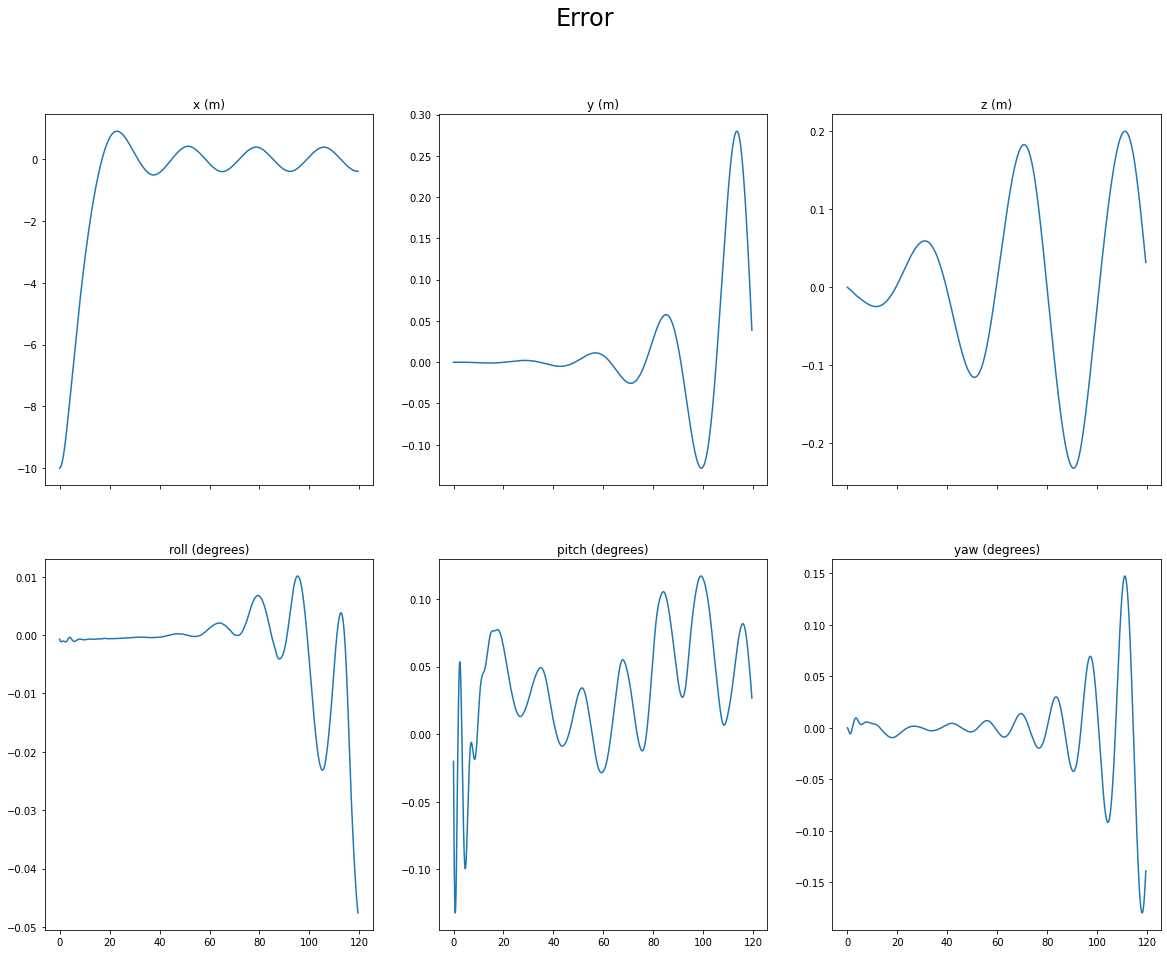

In [5]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle("Error", fontsize=24)

axes[0, 0].plot(traj['Time'] - traj['Time'][0], err[:, 0], label="Cascade")
axes[0, 0].set_title('x (m)')
axes[0, 1].plot(traj['Time'] - traj['Time'][0], err[:, 1])
axes[0, 1].set_title('y (m)')
axes[0, 2].plot(traj['Time'] - traj['Time'][0], err[:, 2])
axes[0, 2].set_title('z (m)')
# Angles
axes[1, 0].plot(traj['Time'] - traj['Time'][0], err[:, 3])
axes[1, 0].set_title('roll (degrees)')
axes[1, 1].plot(traj['Time'] - traj['Time'][0], err[:, 4])
axes[1, 1].set_title('pitch (degrees)')
axes[1, 2].plot(traj['Time'] - traj['Time'][0], err[:, 5])
axes[1, 2].set_title('yaw (degrees)')

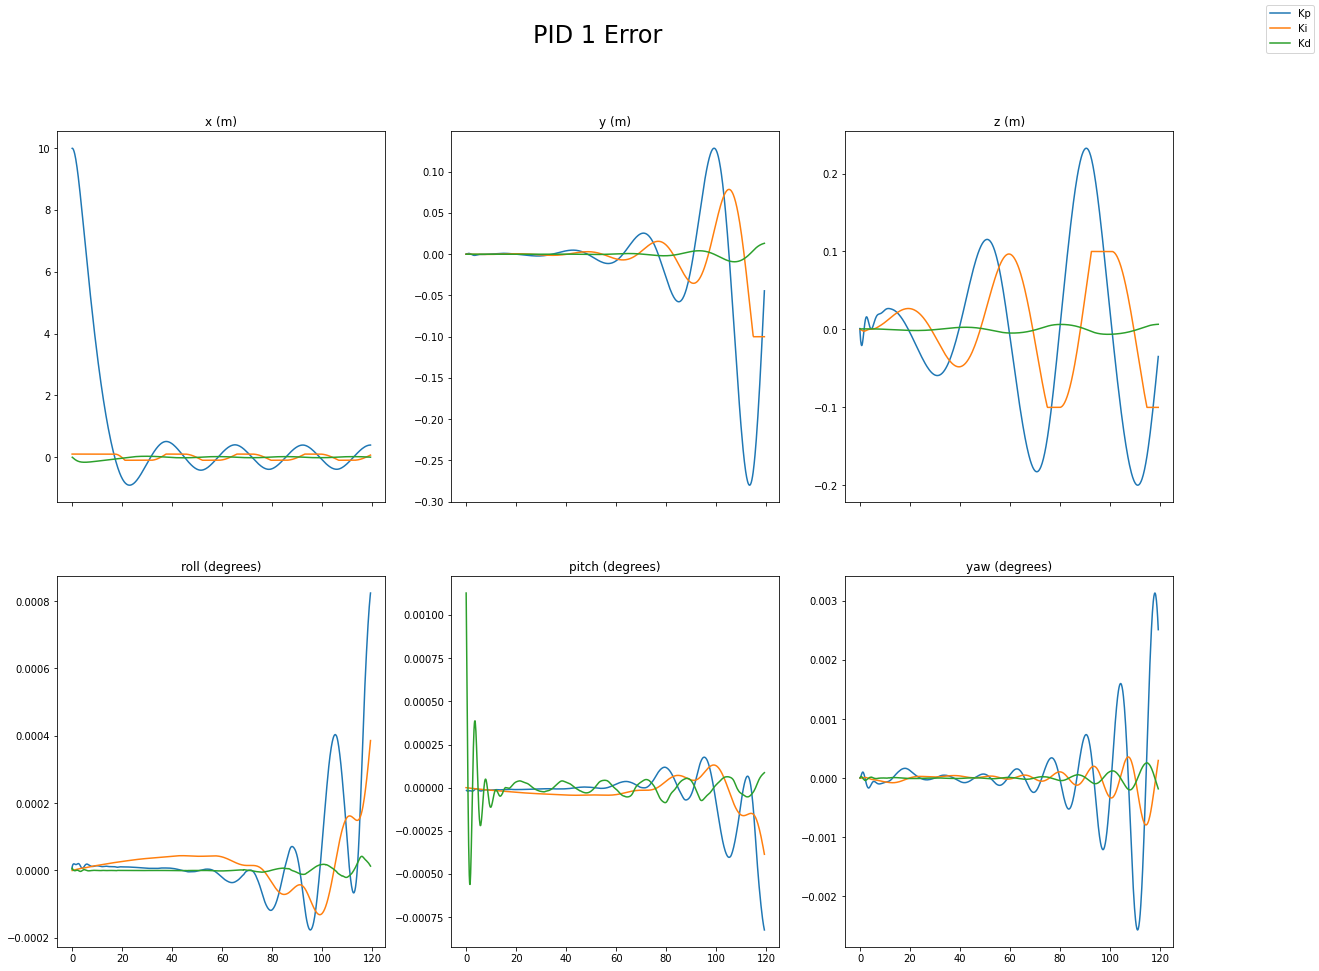

In [6]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle("PID 1 Error", fontsize=24)

axes[0, 0].plot(trajs_pid1_e_t[0] - traj['Time'][0], trajs_pid1_e[0], label="Kp")
axes[0, 0].plot(trajs_pid1_e_t[0+6] - traj['Time'][0], trajs_pid1_e[0+6], label="Ki")
axes[0, 0].plot(trajs_pid1_e_t[0+12] - traj['Time'][0], trajs_pid1_e[0+12], label="Kd")
axes[0, 0].set_title('x (m)')

axes[0, 1].plot(trajs_pid1_e_t[1] - traj['Time'][0], trajs_pid1_e[1])
axes[0, 1].plot(trajs_pid1_e_t[1+6] - traj['Time'][0], trajs_pid1_e[1+6])
axes[0, 1].plot(trajs_pid1_e_t[1+12] - traj['Time'][0], trajs_pid1_e[1+12])
axes[0, 1].set_title('y (m)')

axes[0, 2].plot(trajs_pid1_e_t[2] - traj['Time'][0], trajs_pid1_e[2])
axes[0, 2].plot(trajs_pid1_e_t[2+6] - traj['Time'][0], trajs_pid1_e[2+6])
axes[0, 2].plot(trajs_pid1_e_t[2+12] - traj['Time'][0], trajs_pid1_e[2+12])
axes[0, 2].set_title('z (m)')
# Angles
axes[1, 0].plot(trajs_pid1_e_t[3] - traj['Time'][0], trajs_pid1_e[3])
axes[1, 0].plot(trajs_pid1_e_t[3+6] - traj['Time'][0], trajs_pid1_e[3+6])
axes[1, 0].plot(trajs_pid1_e_t[3+12] - traj['Time'][0], trajs_pid1_e[3+12])
axes[1, 0].set_title('roll (degrees)')

axes[1, 1].plot(trajs_pid1_e_t[4] - traj['Time'][0], trajs_pid1_e[4])
axes[1, 1].plot(trajs_pid1_e_t[4+6] - traj['Time'][0], trajs_pid1_e[4+6])
axes[1, 1].plot(trajs_pid1_e_t[4+12] - traj['Time'][0], trajs_pid1_e[4+12])
axes[1, 1].set_title('pitch (degrees)')

axes[1, 2].plot(trajs_pid1_e_t[5] - traj['Time'][0], trajs_pid1_e[5])
axes[1, 2].plot(trajs_pid1_e_t[5+6] - traj['Time'][0], trajs_pid1_e[5+6])
axes[1, 2].plot(trajs_pid1_e_t[5+12] - traj['Time'][0], trajs_pid1_e[5+12])
axes[1, 2].set_title('yaw (degrees)')

fig.legend()
plt.show()

No handles with labels found to put in legend.


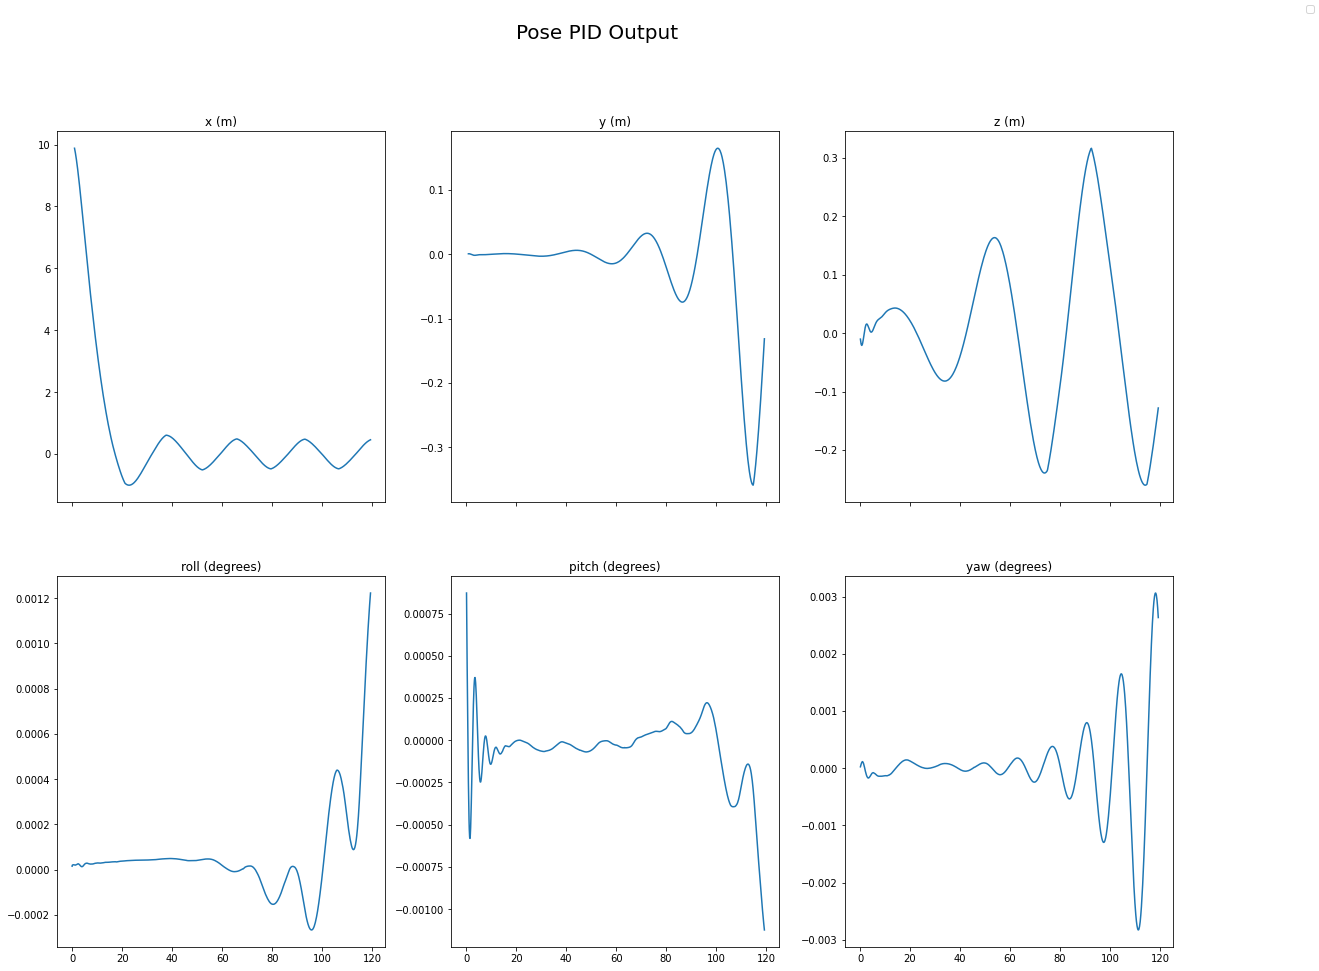

In [7]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle("Pose PID Output", fontsize=20)

axes[0, 0].plot(trajs_pid1_o_t[0] - traj['Time'][0], trajs_pid1_o[0])
axes[0, 0].set_title('x (m)')

axes[0, 1].plot(trajs_pid1_o_t[1] - traj['Time'][0], trajs_pid1_o[1])
axes[0, 1].set_title('y (m)')

axes[0, 2].plot(trajs_pid1_o_t[2] - traj['Time'][0], trajs_pid1_o[2])
axes[0, 2].set_title('z (m)')
# Angles
axes[1, 0].plot(trajs_pid1_o_t[3] - traj['Time'][0], trajs_pid1_o[3])
axes[1, 0].set_title('roll (degrees)')

axes[1, 1].plot(trajs_pid1_o_t[4] - traj['Time'][0], trajs_pid1_o[4])
axes[1, 1].set_title('pitch (degrees)')

axes[1, 2].plot(trajs_pid1_o_t[5] - traj['Time'][0], trajs_pid1_o[5])
axes[1, 2].set_title('yaw (degrees)')

fig.legend()
plt.show()

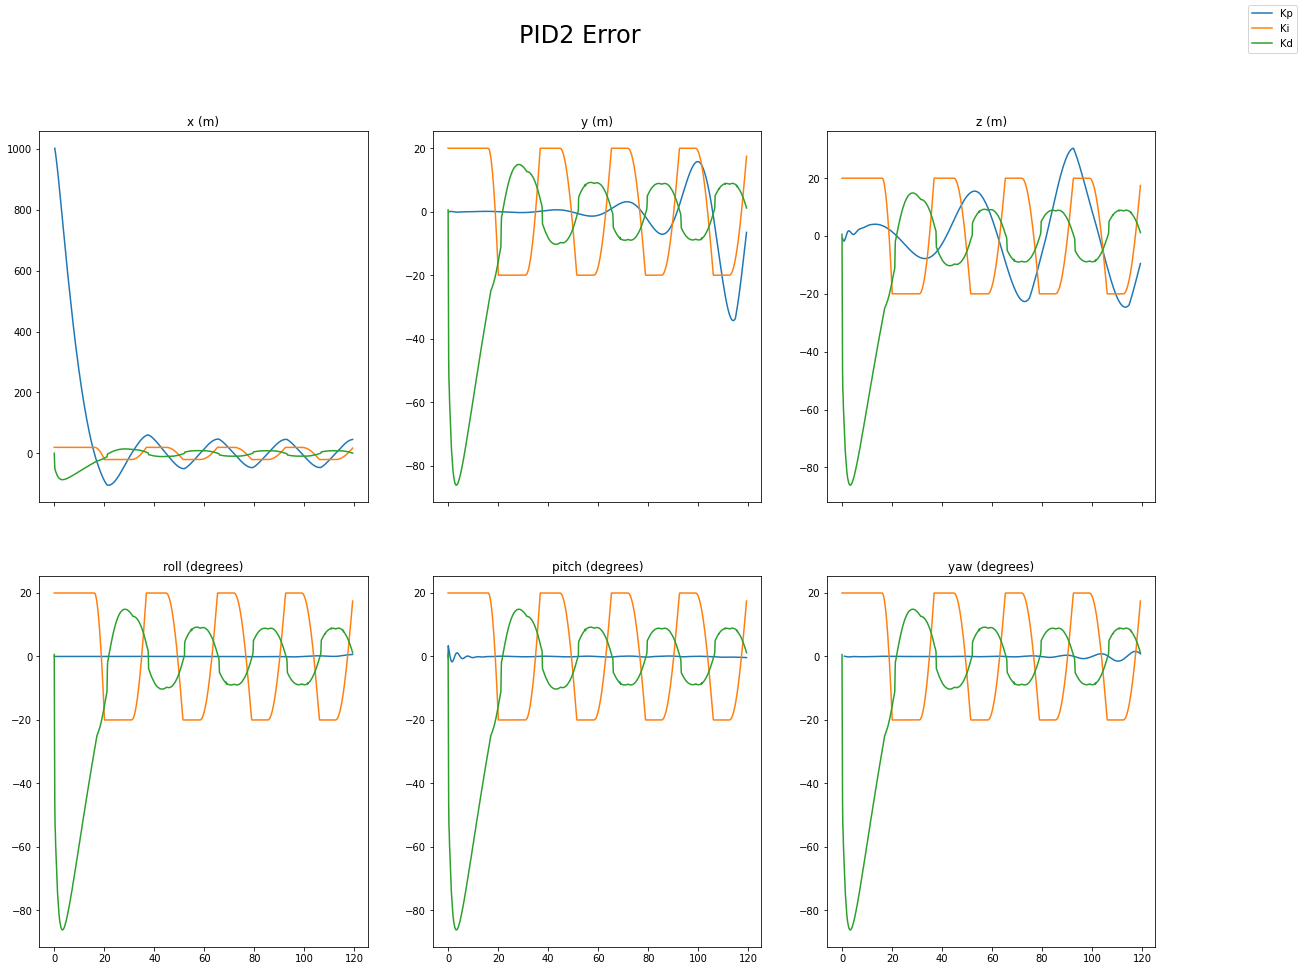

In [8]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle("PID2 Error", fontsize=24)


axes[0, 0].plot(trajs_pid2_e_t[0] - traj['Time'][0], trajs_pid2_e[0], label="Kp")
axes[0, 0].plot(trajs_pid2_e_t[0+6] - traj['Time'][0], trajs_pid2_e[0+6], label="Ki")
axes[0, 0].plot(trajs_pid2_e_t[0+12] - traj['Time'][0], trajs_pid2_e[0+12], label="Kd")
axes[0, 0].set_title('x (m)')

axes[0, 1].plot(trajs_pid2_e_t[1] - traj['Time'][0], trajs_pid2_e[1])
axes[0, 1].plot(trajs_pid2_e_t[0+6] - traj['Time'][0], trajs_pid2_e[0+6])
axes[0, 1].plot(trajs_pid2_e_t[0+12] - traj['Time'][0], trajs_pid2_e[0+12])
axes[0, 1].set_title('y (m)')

axes[0, 2].plot(trajs_pid2_e_t[2] - traj['Time'][0], trajs_pid2_e[2])
axes[0, 2].plot(trajs_pid2_e_t[0+6] - traj['Time'][0], trajs_pid2_e[0+6])
axes[0, 2].plot(trajs_pid2_e_t[0+12] - traj['Time'][0], trajs_pid2_e[0+12])
axes[0, 2].set_title('z (m)')
# Angles
axes[1, 0].plot(trajs_pid2_e_t[3] - traj['Time'][0], trajs_pid2_e[3])
axes[1, 0].plot(trajs_pid2_e_t[0+6] - traj['Time'][0], trajs_pid2_e[0+6])
axes[1, 0].plot(trajs_pid2_e_t[0+12] - traj['Time'][0], trajs_pid2_e[0+12])
axes[1, 0].set_title('roll (degrees)')

axes[1, 1].plot(trajs_pid2_e_t[4] - traj['Time'][0], trajs_pid2_e[4])
axes[1, 1].plot(trajs_pid2_e_t[0+6] - traj['Time'][0], trajs_pid2_e[0+6])
axes[1, 1].plot(trajs_pid2_e_t[0+12] - traj['Time'][0], trajs_pid2_e[0+12])
axes[1, 1].set_title('pitch (degrees)')

axes[1, 2].plot(trajs_pid2_e_t[5] - traj['Time'][0], trajs_pid2_e[5])
axes[1, 2].plot(trajs_pid2_e_t[0+6] - traj['Time'][0], trajs_pid2_e[0+6])
axes[1, 2].plot(trajs_pid2_e_t[0+12] - traj['Time'][0], trajs_pid2_e[0+12])
axes[1, 2].set_title('yaw (degrees)')

fig.legend()
plt.show()

No handles with labels found to put in legend.


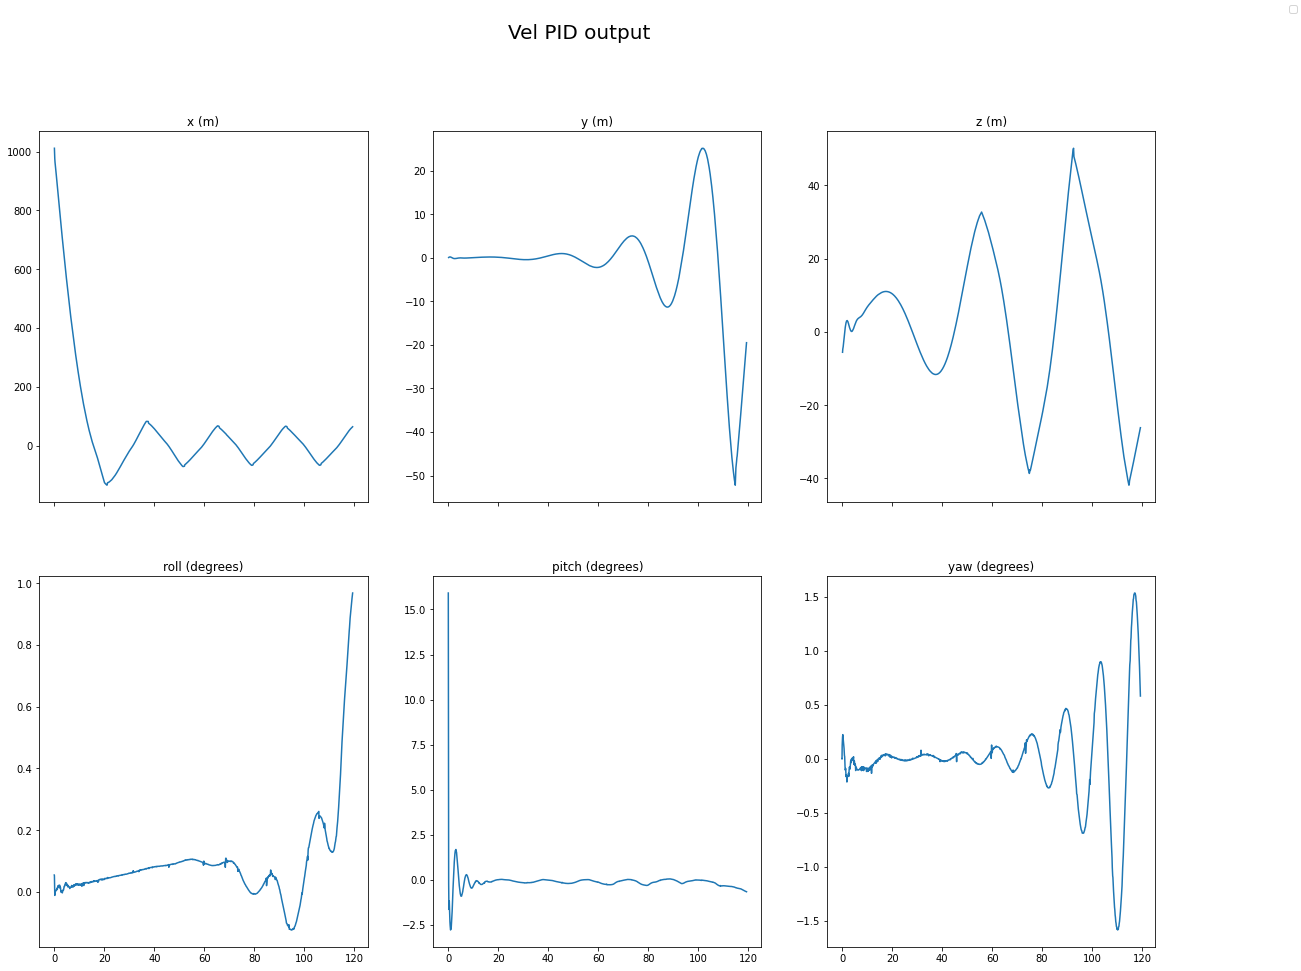

In [9]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle("Vel PID output", fontsize=20)

axes[0, 0].plot(trajs_pid2_o_t[0] - traj['Time'][0], trajs_pid2_o[0])
axes[0, 0].set_title('x (m)')

axes[0, 1].plot(trajs_pid2_o_t[1] - traj['Time'][0], trajs_pid2_o[1])
axes[0, 1].set_title('y (m)')

axes[0, 2].plot(trajs_pid2_o_t[2] - traj['Time'][0], trajs_pid2_o[2])
axes[0, 2].set_title('z (m)')
# Angles
axes[1, 0].plot(trajs_pid2_o_t[3] - traj['Time'][0], trajs_pid2_o[3])
axes[1, 0].set_title('roll (degrees)')

axes[1, 1].plot(trajs_pid2_o_t[4] - traj['Time'][0], trajs_pid2_o[4])
axes[1, 1].set_title('pitch (degrees)')

axes[1, 2].plot(trajs_pid2_o_t[5] - traj['Time'][0], trajs_pid2_o[5])
axes[1, 2].set_title('yaw (degrees)')

fig.legend()
plt.show()

No handles with labels found to put in legend.


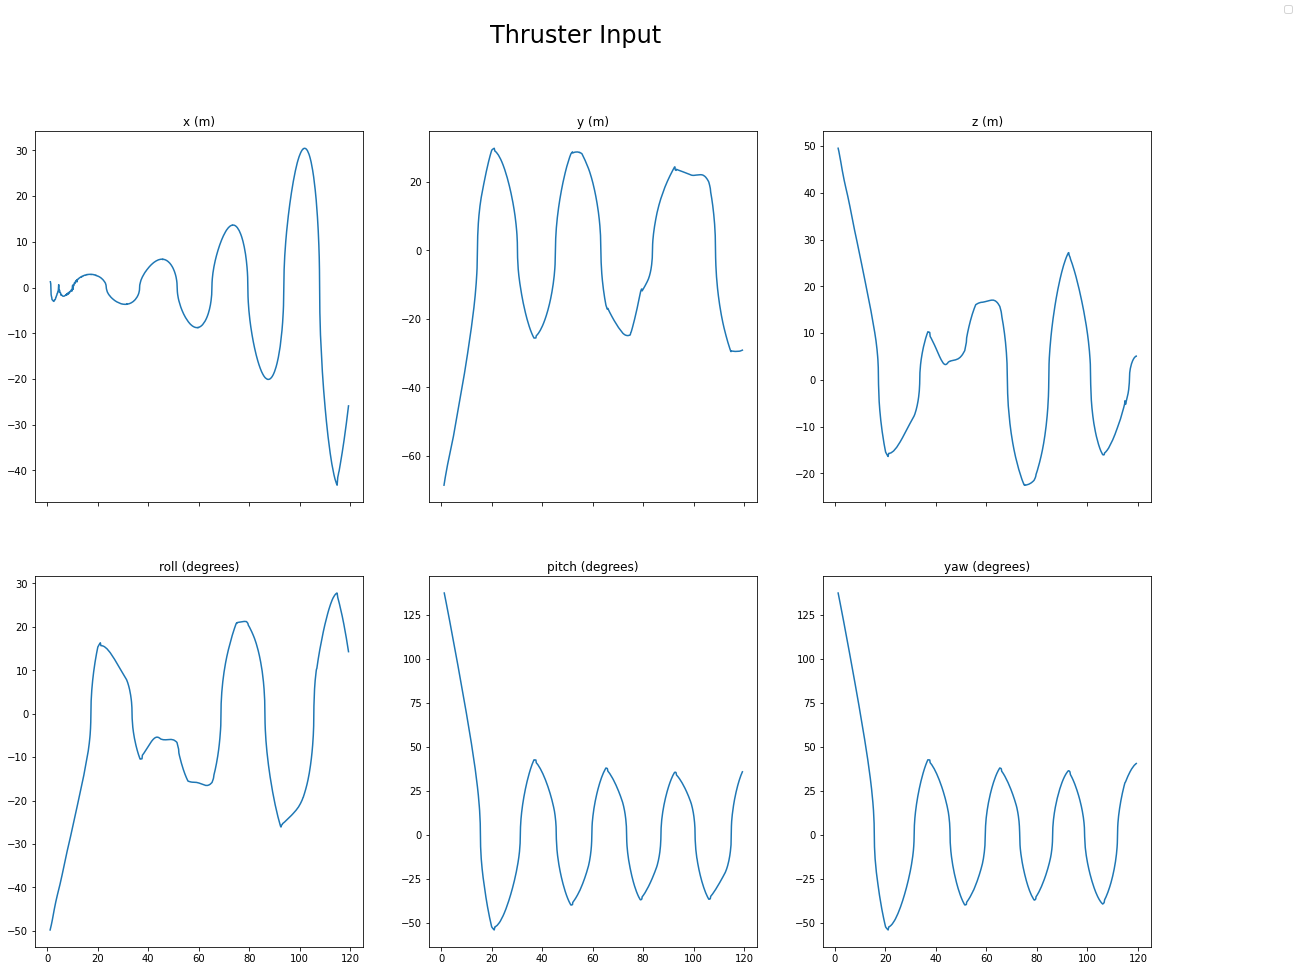

In [10]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(15)
fig.set_figwidth(20)
fig.suptitle("Thruster Input", fontsize=24)

axes[0, 0].plot(trajs_thrust_t[0] - traj['Time'][0], trajs_thrust[0])
axes[0, 0].set_title('x (m)')

axes[0, 1].plot(trajs_thrust_t[1] - traj['Time'][0], trajs_thrust[1])
axes[0, 1].set_title('y (m)')

axes[0, 2].plot(trajs_thrust_t[2] - traj['Time'][0], trajs_thrust[2])
axes[0, 2].set_title('z (m)')
# Angles
axes[1, 0].plot(trajs_thrust_t[3] - traj['Time'][0], trajs_thrust[3])
axes[1, 0].set_title('roll (degrees)')

axes[1, 1].plot(trajs_thrust_t[4] - traj['Time'][0], trajs_thrust[4])
axes[1, 1].set_title('pitch (degrees)')

axes[1, 2].plot(trajs_thrust_t[5] - traj['Time'][0], trajs_thrust[5])
axes[1, 2].set_title('yaw (degrees)')

fig.legend()
plt.show()